## Import library

fast.ai 
Practical Deep Learning for Coders 

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.optimizers as opt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, MaxPooling1D, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input

## Define path & total number

In [2]:
path = "./img_sub/cat"
dirlist = os.listdir(path)
catPath = [os.path.join(path, dirname) for dirname in dirlist]
# path_noncat = os.path.join(path, 'no_cat')


# train_dir = 'C:/Users/cs623/.keras/datasets/cats_and_dogs_filtered/train'
# validation_dir = 'C:/Users/cs623/.keras/datasets/cats_and_dogs_filtered/validation'
# train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
# train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
# validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
# validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [3]:
total_img_num = sum(map(len,map(os.listdir, catPath)))
print('all kinds of cats: ', dirlist)
for i in range(len(catPath)):
    print(dirlist[i], ': ', len(os.listdir(catPath[i])))
print('total cat imgs: ', total_img_num)

all kinds of cats:  ['bljfm', 'bom', 'dlm', 'fksm', 'jjc', 'jm', 'lm', 'md', 'mgbwm', 'mmm', 'mym', 'nnm', 'xmly', 'yjc', 'zem']
bljfm :  258
bom :  257
dlm :  222
fksm :  222
jjc :  246
jm :  232
lm :  270
md :  258
mgbwm :  235
mmm :  212
mym :  222
nnm :  200
xmly :  204
yjc :  234
zem :  235
total cat imgs:  3507


## Train test split

In [4]:
batch_size = 10
epochs = 60
IMG_HEIGHT = 116
IMG_WIDTH = 116
split = 0.2
classNum = len(dirlist)
total_val = total_img_num * split
total_train = total_img_num * (1 - split)

In [5]:
# Generator

train_datagen = ImageDataGenerator(
    rescale=1./255,rotation_range=40, # Angle, 0-180
    width_shift_range=0.2, # horizontal shifting
    height_shift_range=0.2, # vertical shifting
    shear_range=0.2, # Shearing
    zoom_range=0.2, # Zooming
    horizontal_flip=True, # Flipping
    validation_split=split
)

In [6]:
# Load images from the disk, applies rescaling, and resizes the images

train_generator = train_datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
) # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
) # set as validation data

Found 2811 images belonging to 15 classes.
Found 696 images belonging to 15 classes.


## Samples

In [7]:
sample_img_train, sample_label_train = next(train_generator)

In [8]:
def plotImg(img):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for i, a in zip(img, axes):
        a.imshow(i)
        a.axis("off")
    plt.tight_layout()
    plt.show()

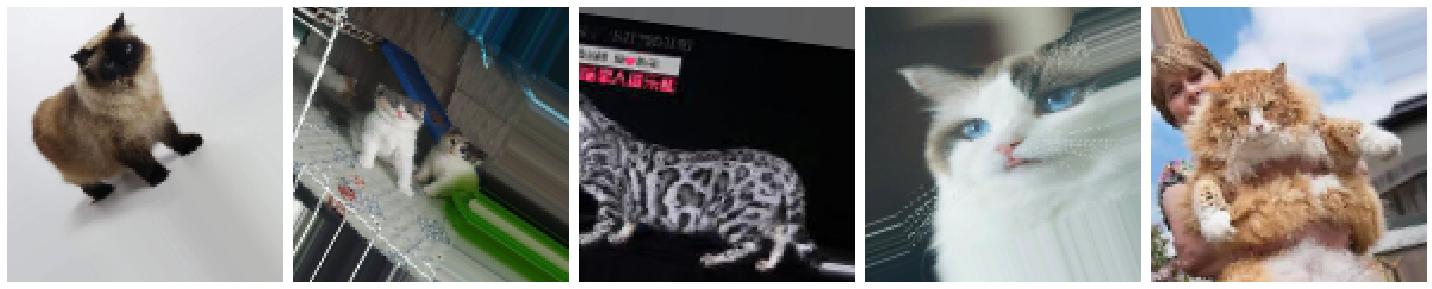

In [9]:
plotImg(sample_img_train[:15])

## Model

In [10]:
VGGNet = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), ),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    # Conv2D(256, 3, padding='same', activation='relu'),
    # Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    # Conv2D(512, 3, padding='same', activation='relu'),
    # Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    # Conv2D(512, 3, padding='same', activation='relu'),
    # Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(classNum, activation='softmax'),
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
model = Sequential([
    Conv2D(32, 3, padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), name = 'cov1'),
    Activation('relu', name = 'act1'),
    Conv2D(32, 3, name = 'cov2'),
    Activation('relu', name = 'act2'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name = 'maxpool1'),
    Dropout(0.25, name = 'drop1'),
    Conv2D(64, 5, padding='same', name = 'cov3'),
    Activation('relu', name = 'act3'),
    Conv2D(64, 5, name = 'cov4'),
    Activation('relu', name = 'act4'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name = 'maxpool2'),
    Dropout(0.25, name = 'drop2'),
    Flatten(name = 'flatten'),
    Dense(512, name = 'dense1'),
    Activation('relu', name = 'act5'),
    Dropout(0.5, name = 'drop3'),
    Dense(classNum, name = 'dense2'),
    Activation('softmax', name = 'act6')
])
# 0.44-0.47 之间

In [12]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.8, nesterov=True)
rms = RMSprop(learning_rate=0.0001, decay=1e-6)

In [13]:
model.compile(optimizer=sgd,
             loss='categorical_crossentropy',
             metrics=['accuracy'],  
             )

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cov1 (Conv2D)                (None, 116, 116, 32)      896       
_________________________________________________________________
act1 (Activation)            (None, 116, 116, 32)      0         
_________________________________________________________________
cov2 (Conv2D)                (None, 114, 114, 32)      9248      
_________________________________________________________________
act2 (Activation)            (None, 114, 114, 32)      0         
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 57, 57, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 57, 57, 32)        0         
_________________________________________________________________
cov3 (Conv2D)                (None, 57, 57, 64)       

## Train model

In [15]:
def get_available_gpus():
    """
    code from http://stackoverflow.com/questions/38559755/how-to-get-current-available-gpus-in-tensorflow
    """
    from tensorflow.python.client import device_lib as _device_lib
    local_device_protos = _device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type == 'CPU']

In [16]:
model.load_weights('./multiclass/f_3355_60.180_weights_1.h5')
model.save('./multiclass/f_3355_60.180.h5')

In [15]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
get_available_gpus()

NameError: name 'get_available_gpus' is not defined

In [ ]:
with tf.device('/gpu:0'):
    model.load_weights('./multiclass/f_3355_60.120_weights_1.h5')
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = total_train // batch_size,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = total_val // batch_size     
    )
model.save_weights('./multiclass/f_3355_60.180_weights_1.h5')
# model.save('3355_1.h5')

## Result visualisation 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
def InceptionNet():
    x_input = Input(shape = (116, 116, 3))
    x = Conv2D(32, 3, padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3))(x_input)
    x = Activation('relu')(x)
    x = Conv2D(32,3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.25)(x)

    x1 = Conv2D(64, 5, padding='same')(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(64, 5)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(64, 5, padding='same')(x)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(64, 5)(x2)
    x2 = Activation('relu')(x2)

    x = concatenate([x1, x2], axis = -1)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(521)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(classNum)(x)
    x = Activation('softmax')(x)

    model = Model(inputs = x_input, outputs = x, name = 'tryInception')
    return model

In [ ]:
incep = InceptionNet()

In [ ]:
incep.compile(optimizer=sgd,
             loss='categorical_crossentropy',
             metrics=['accuracy'],  
             )
incep.summary()

In [ ]:
plot_model(incep, 'simplified_inception.png', show_shapes=True)

In [ ]:
with tf.device('/gpu:0'):
    history = incep.fit_generator(
        train_generator,
        steps_per_epoch = total_train // batch_size,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = total_val // batch_size     
    )

In [ ]:
incep.save_weights('./multiclass/incp_3355_120_weights.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()